In [4]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

# Get data

In [5]:
df_annotations = pd.read_pickle("filtered_for_arm.pkl")

In [7]:
# df_annotations.to_csv("filtered_for_arm.pkl.csv.bz2", encoding="utf-8", index=False)

In [3]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [4]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

/tmp/ipykernel_5362/3303076186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)


In [5]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [6]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import make_pipeline

In [8]:
NUM_FEATURES = 1500


stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True,
                         stop_words = stops, max_features= NUM_FEATURES,
                             ngram_range=[1,2]
                            )
transformer = TfidfTransformer()

nb = MultinomialNB()
nb = ComplementNB()
model = make_pipeline(vectoriser, transformer, nb)

In [9]:
model.fit(df_train.text, df_train.num_arms_clean)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, ngram_range=[1, 2],
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('complementnb', ComplementNB())])

In [10]:
df_val["pred_num_arms"]  = model.predict(df_val.text)

/tmp/ipykernel_5362/3033820389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms"]  = model.predict(df_val.text)


In [11]:
pred_num_arms = df_val["pred_num_arms"]
num_arms_ground_truths = df_val.num_arms_clean

In [12]:
pred_num_arms.value_counts()

2.0    549
1.0    361
5.0    104
3.0     38
4.0      4
Name: pred_num_arms, dtype: int64

In [13]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.5975378787878788


''

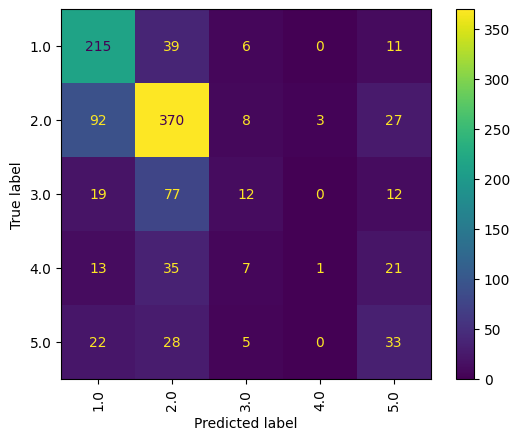

In [14]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;

In [15]:
vectoriser.vocabulary_

{'medications': 843,
 'studies': 1312,
 'groups': 664,
 'cell': 309,
 'counts': 407,
 'children': 321,
 'clinical': 332,
 'efficacy': 523,
 'age': 178,
 'group': 644,
 'effects': 522,
 'chronic': 323,
 'end': 540,
 'organ': 950,
 'rationale': 1134,
 'overview': 961,
 'term': 1379,
 'disease': 474,
 '15': 26,
 'cells': 310,
 'cohort': 341,
 'infants': 723,
 '24': 60,
 'months': 883,
 'observed': 926,
 'time': 1395,
 'two': 1433,
 'investigators': 756,
 'presented': 1063,
 'evidence': 580,
 'therapy': 1389,
 'associated': 250,
 'lower': 811,
 'patients': 979,
 'study': 1313,
 'reported': 1175,
 'incidence': 708,
 'acute': 159,
 'leukemia': 789,
 '51': 103,
 'adults': 171,
 'treated': 1412,
 'may': 827,
 'compared': 362,
 'al': 184,
 'given': 637,
 'number': 917,
 'provided': 1099,
 'preliminary': 1061,
 'data': 426,
 'well': 1486,
 'tolerated': 1404,
 'laboratory': 777,
 'similar': 1266,
 'toxicities': 1407,
 'growth': 668,
 'development': 461,
 'occurrence': 931,
 'adverse': 173,
 'even

In [16]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")

Strongest predictors for class 0

0	ecog
1	single
2	label single
3	oncology
4	southwest
5	arm open
6	cancer
7	clin
8	acrin
9	eastern
10	cohort
11	single arm
12	expansion
13	oncol
14	performance
15	cooperative
16	label
17	arm phase
18	phase
19	ii
20	prostate
21	open
22	ii study
23	nci
24	open label
25	lymphoma
26	oncology group
27	leukemia
28	relapsed
29	breast
30	carcinoma
31	dose limiting
32	southwest oncology
33	electrocardiogram
34	patients
35	survival
36	group version
37	myeloma
38	marrow
39	update
40	melanoma
41	ecog acrin
42	limiting
43	cancer research
44	ecg electrocardiogram
45	working
46	study study
47	phase ii
48	clin oncol
49	historical
50	phase iii
51	refractory
52	ipsen
53	group clin
54	study
55	platinum
56	metastatic
57	lenalidomide
58	tumors
59	response criteria
60	transplant
61	prostate cancer
62	arm study
63	free
64	chair
65	advanced
66	nsclc
67	gemcitabine
68	recurrent
69	registration
70	bevacizumab
71	m2
72	ecog performance
73	group ecog
74	l1
75	radiation
76	breast 

692	bp
693	alirocumab
694	sub
695	ae
696	state
697	medical
698	failure
699	requirements
700	duration
701	statistically
702	combined
703	result
704	administration
705	mk
706	iv
707	note
708	included
709	vs
710	enrollment
711	level
712	determine
713	thus
714	apr
715	doses
716	type
717	plus
718	confidential page
719	also
720	may
721	per cohort
722	inclusion criteria
723	responders
724	volume
725	2020
726	purpose
727	least one
728	three
729	infusion
730	independent
731	group compared
732	history
733	collection
734	methods
735	except
736	administered
737	decrease
738	reference
739	study procedures
740	dosed
741	rate
742	selected
743	study subjects
744	us
745	eligibility criteria
746	obtained
747	summary
748	permitted
749	normal
750	dose group
751	subjects receive
752	followed
753	all cohorts
754	four
755	eot
756	severe
757	study treatment
758	improvement
759	greater
760	recorded
761	blood samples
762	statistically significant
763	within cohort
764	concentration
765	participation
766	modifie

1308	study groups
1309	proportion patients
1310	visit treatment
1311	eq 5d
1312	efficacy endpoint
1313	statistics
1314	interim
1315	points
1316	day day
1317	alpha
1318	blind placebo
1319	5d
1320	randomized double
1321	part cohort
1322	groups compared
1323	confidence interval
1324	baseline week
1325	regression
1326	week 12
1327	point
1328	models
1329	rank test
1330	subjects per
1331	assumed
1332	presented treatment
1333	patients arm
1334	subjects randomized
1335	gs
1336	randomised
1337	tablet
1338	patients randomized
1339	demographic
1340	switch
1341	proportions
1342	standard
1343	number property
1344	both groups
1345	mean change
1346	group using
1347	q4w
1348	descriptive
1349	success
1350	tablets
1351	glucose
1352	sequence
1353	hospital
1354	group strictly
1355	allocated
1356	blind parallel
1357	two sided
1358	study arm
1359	randomized treatment
1360	tak
1361	unblinding
1362	group randomized
1363	assigned treatment
1364	randomly assigned
1365	care
1366	property sanofi
1367	log rank
136

466	percent
467	severity
468	within
469	investigators
470	day
471	subgroup
472	concomitant
473	site
474	serious
475	sanofi group
476	treatments
477	48
478	medical
479	time points
480	independent
481	total number
482	injections
483	end study
484	reports
485	events
486	according
487	recorded
488	provided
489	84
490	activities
491	tabulated
492	analysis set
493	30
494	arm compared
495	severe
496	vs
497	cases
498	methods
499	eligible subjects
500	sequential
501	factor
502	members
503	less
504	tablets
505	normal
506	required
507	40
508	individuals
509	limit
510	alfa
511	infection
512	infusion
513	body
514	pregnancy
515	oral
516	scale
517	intravenous
518	significantly
519	include
520	global
521	corresponding
522	initiation
523	saes
524	conducted
525	every
526	exclusion criteria
527	12 week
528	laboratory
529	benefit
530	evaluations
531	20
532	modification
533	times
534	safety analysis
535	time point
536	otherwise
537	groups respectively
538	60
539	twice
540	interest
541	associated
542	practi

1163	injection site
1164	treated
1165	old
1166	european
1167	chronic
1168	revised
1169	10 patients
1170	receptor
1171	april
1172	status
1173	july
1174	rituximab
1175	acceptable
1176	decision
1177	imaging
1178	pharmacokinetic
1179	blood samples
1180	pooled
1181	previously
1182	optional
1183	ps
1184	toxicities
1185	version date
1186	overview
1187	companies
1188	subjects received
1189	day cycle
1190	closed
1191	formulation
1192	10 mg
1193	toxicity
1194	300 mg
1195	considerations
1196	overall survival
1197	protocol version
1198	07
1199	combination arm
1200	adult
1201	trial protocol
1202	clinical study
1203	240
1204	safe
1205	report
1206	september
1207	ct
1208	long term
1209	mg day
1210	800
1211	ongoing
1212	dmc
1213	international
1214	four
1215	bp
1216	ctcae
1217	three
1218	patients treated
1219	discussion
1220	1a
1221	gemcitabine
1222	upper
1223	safety monitoring
1224	group performance
1225	06
1226	group companies
1227	remaining
1228	third
1229	title
1230	eg
1231	men
1232	pr
1233	portion


249	52
250	nivolumab
251	signs
252	section
253	stopped
254	mg qd
255	remaining
256	demographic baseline
257	confidential
258	safety analyses
259	percentage subjects
260	influenza
261	efficacy analysis
262	samples
263	number percentage
264	next cohort
265	pk data
266	twice daily
267	intervals
268	tables
269	profile
270	secondary endpoints
271	dose cohort
272	points
273	plus
274	concomitant medications
275	years age
276	treatment groups
277	changes baseline
278	concentration
279	subjects assigned
280	randomized arm
281	analyses
282	study medication
283	described
284	randomly
285	covariate
286	biomarker
287	eligible subjects
288	randomized receive
289	antibodies
290	99
291	fas
292	corresponding
293	ancova
294	mg kg
295	tablets
296	tabulated
297	multi center
298	period
299	vital signs
300	medications
301	primary objective
302	follows
303	continue
304	key
305	concentrations
306	minimum
307	group study
308	reasons
309	repeated
310	revised
311	us
312	combination
313	samples collected
314	high

875	minutes
876	group subjects
877	follow
878	initiated
879	sided 95
880	cumulative
881	description
882	26
883	without
884	participation
885	vs
886	dose escalation
887	72
888	50
889	phase study
890	must
891	body
892	personnel
893	44
894	study cohort
895	64
896	demographics
897	saes
898	subsequent
899	infusion
900	shown
901	effect
902	time
903	first
904	70
905	pr
906	arm
907	form
908	dosed
909	estimate
910	normal
911	independent
912	duration
913	determine
914	medical
915	none
916	glaxosmithkline group
917	documented
918	13
919	compliance
920	inclusion criteria
921	higher
922	18
923	local
924	contact
925	immediately
926	eligibility
927	dlt
928	name
929	muscle
930	auc
931	treatment assignment
932	average
933	major
934	serious adverse
935	65
936	cycles
937	five
938	35
939	overall
940	show
941	41
942	interval
943	team
944	specific
945	anti
946	14
947	upper
948	acid
949	11
950	aml
951	reported
952	subjects arm
953	measured
954	received
955	per group
956	proportions
957	standard deviation
958

0	mg
1	cohort
2	1b
3	dose
4	subjects
5	sanofi
6	group group
7	phase cohort
8	property
9	bms
10	four
11	cohort cohort
12	qd
13	phase 1b
14	mg qd
15	tablet
16	protocol final
17	pf
18	part
19	sentinel
20	within cohort
21	day
22	april
23	strictly
24	1a
25	q4w
26	durvalumab
27	gs
28	q2w
29	number property
30	cohorts
31	ipsen
32	15 mg
33	version number
34	taf
35	hepatic
36	2a
37	cohort may
38	50 mg
39	next cohort
40	tablets
41	rp2d
42	800
43	property sanofi
44	sanofi group
45	200
46	per cohort
47	cohort part
48	mg day
49	mk
50	dose group
51	cohort dose
52	expansion
53	volunteers
54	subjects cohort
55	300
56	confidential protocol
57	enrolled cohort
58	vaccination
59	pooled
60	periods
61	tak
62	pharmacodynamic
63	kg day
64	titration
65	tolerability
66	part cohort
67	glaxosmithkline
68	pk
69	pk data
70	infants
71	single dose
72	200 mg
73	180
74	vaccine
75	group strictly
76	cohort subjects
77	subset
78	pk pd
79	confidential
80	week 24
81	bp
82	sequence
83	remaining
84	text
85	600
86	vital
87	imp

684	48
685	oral
686	based
687	requirements
688	including
689	ongoing
690	tolerated
691	initially
692	using descriptive
693	collection
694	85
695	weeks
696	study population
697	occur
698	combination therapy
699	prior
700	37
701	lead
702	chronic
703	activity
704	regulatory
705	equal
706	co
707	times
708	participants
709	increased
710	covariate
711	mean change
712	relative
713	modified
714	aes
715	obtain
716	potential
717	safety analyses
718	generated
719	update
720	change
721	area
722	evaluated
723	first
724	include
725	human
726	observed
727	changes
728	one
729	synopsis
730	mg group
731	po
732	provide
733	also
734	cases
735	unblinding
736	anti
737	terms
738	26
739	subjects treatment
740	summary statistics
741	title
742	49
743	description
744	65
745	diabetes
746	history
747	preliminary
748	general
749	examination
750	research group
751	54
752	primary efficacy
753	order
754	follow
755	version
756	post
757	appropriate
758	participant
759	higher
760	descriptive
761	safety analysis
762	sd
76

1314	improvement
1315	cooperative oncology
1316	detect
1317	death
1318	placebo groups
1319	two sided
1320	free survival
1321	rates
1322	need
1323	block
1324	years
1325	children
1326	regression
1327	compare
1328	os
1329	scores
1330	exact test
1331	bevacizumab
1332	progression free
1333	hypothesis
1334	reports
1335	study arms
1336	ps
1337	patients randomized
1338	lung
1339	recurrent
1340	median pfs
1341	group performance
1342	groups compared
1343	itt population
1344	tumors
1345	ecog performance
1346	fisher exact
1347	advanced
1348	registration
1349	growth
1350	influenza
1351	significance level
1352	intervention
1353	significance
1354	pilot
1355	combination arm
1356	ct
1357	median
1358	proportion patients
1359	pediatric
1360	cancer research
1361	bleeding
1362	response criteria
1363	group ecog
1364	gemcitabine
1365	95 confidence
1366	surgical
1367	12 months
1368	infections
1369	sided 95
1370	null
1371	working
1372	group clin
1373	center
1374	covid
1375	80 power
1376	marrow
1377	refractory


467	allow
468	continue
469	start
470	blind placebo
471	via
472	described
473	numbers
474	female
475	prior
476	toxicities
477	termination
478	regimen
479	within
480	evaluations
481	antibodies
482	four
483	reasons
484	scheduled
485	selection
486	must
487	skin
488	listed
489	organ class
490	study drug
491	rationale
492	actual
493	age group
494	specific
495	state
496	take
497	intervals
498	unless
499	per protocol
500	includes
501	purpose
502	analysis performed
503	infusion
504	arm arm
505	following
506	list
507	system organ
508	43
509	mar
510	subjects randomized
511	immediately
512	staff
513	initiation
514	objectives
515	title
516	previously
517	responses
518	systemic
519	data
520	iv
521	observed
522	summary
523	experienced
524	discussion
525	aes
526	across treatment
527	phase
528	tested
529	placebo controlled
530	committee
531	30
532	study treatment
533	abnormalities
534	tumor
535	study protocol
536	assessment
537	without
538	taken
539	anti
540	14
541	exploratory
542	throughout
543	approp

1087	randomization
1088	primary efficacy
1089	tumors
1090	sample
1091	po
1092	patients treatment
1093	clinical trials
1094	population
1095	property sanofi
1096	small
1097	study visit
1098	show
1099	multicenter
1100	continuous
1101	percentages
1102	ps
1103	001
1104	international
1105	physical
1106	efficacy endpoint
1107	demographics
1108	placebo arm
1109	participation
1110	term
1111	secondary endpoints
1112	allocation
1113	generated
1114	health
1115	group study
1116	mean
1117	therapy
1118	regardless
1119	low
1120	management
1121	growth
1122	date
1123	low dose
1124	recruitment
1125	benefit
1126	34
1127	long term
1128	2012
1129	acute
1130	analyses
1131	control groups
1132	stable
1133	measure
1134	pediatric
1135	although
1136	interest
1137	2008
1138	estimate
1139	2010
1140	exclusion
1141	children
1142	soc
1143	assuming
1144	high
1145	versus
1146	course
1147	race
1148	randomized subjects
1149	cancer research
1150	proportions
1151	statistically significant
1152	size
1153	done
1154	non
1155	l